## Summary

The primary objective of this analysis is to develop and evaluate deep learning models for image classification of finger signs using convolutional neural networks (CNNs). This project focuses on supervised learning to maximize classification accuracy for recognizing finger signs, which can be beneficial for applications such as sign language interpretation, human-computer interaction, and assistive technologies. The analysis provides valuable insights for stakeholders, such as developers of accessibility tools, enabling effective communication for individuals with speech or hearing impairments.

## Load and Explore the Dataset

The dataset contains images of finger signs categorized into six classes. It is split into training (864 samples), validation (216 samples), and testing (120 samples) sets, with each image having dimensions of 64×64×3 pixels. The dataset was preprocessed to normalize pixel values and encode class labels into one-hot vectors. The goal of this analysis is to design and compare CNN models to achieve high accuracy in identifying the correct finger sign from an image.

Exploratory analysis revealed balanced class distributions and consistent image resolutions across the dataset. Key preprocessing actions included:
* Normalization of pixel values to a range of 
* Encoding of class labels into one-hot vectors.
* Splitting data into training, validation, and testing sets for model evaluation. These steps ensured the data was suitable for training and testing deep learning models.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import h5py
import warnings
from datetime import datetime
import keras
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications import *
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
train_file_path = 'Signs_Data_Training.h5'
test_file_path = 'Signs_Data_Testing.h5'

# Training data
with h5py.File(train_file_path, 'r') as train_hdf:
    list_classes_train = train_hdf['list_classes'][:]
    x_train = train_hdf['train_set_x'][:] 
    y_train = train_hdf['train_set_y'][:] 

# Testing data
with h5py.File(test_file_path, 'r') as test_hdf:
    list_classes_test = test_hdf['list_classes'][:]
    x_test = test_hdf['test_set_x'][:]  # Testing images
    y_test = test_hdf['test_set_y'][:]  # Testing labels

# Validation data
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print("Training images shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing images shape:", x_test.shape)
print("Testing labels shape:", y_test.shape)
print("Validation set images shape:", x_val.shape)
print("Validation set labels shape:", y_val.shape)

Training images shape: (864, 64, 64, 3)
Training labels shape: (864,)
Testing images shape: (120, 64, 64, 3)
Testing labels shape: (120,)
Validation set images shape: (216, 64, 64, 3)
Validation set labels shape: (216,)


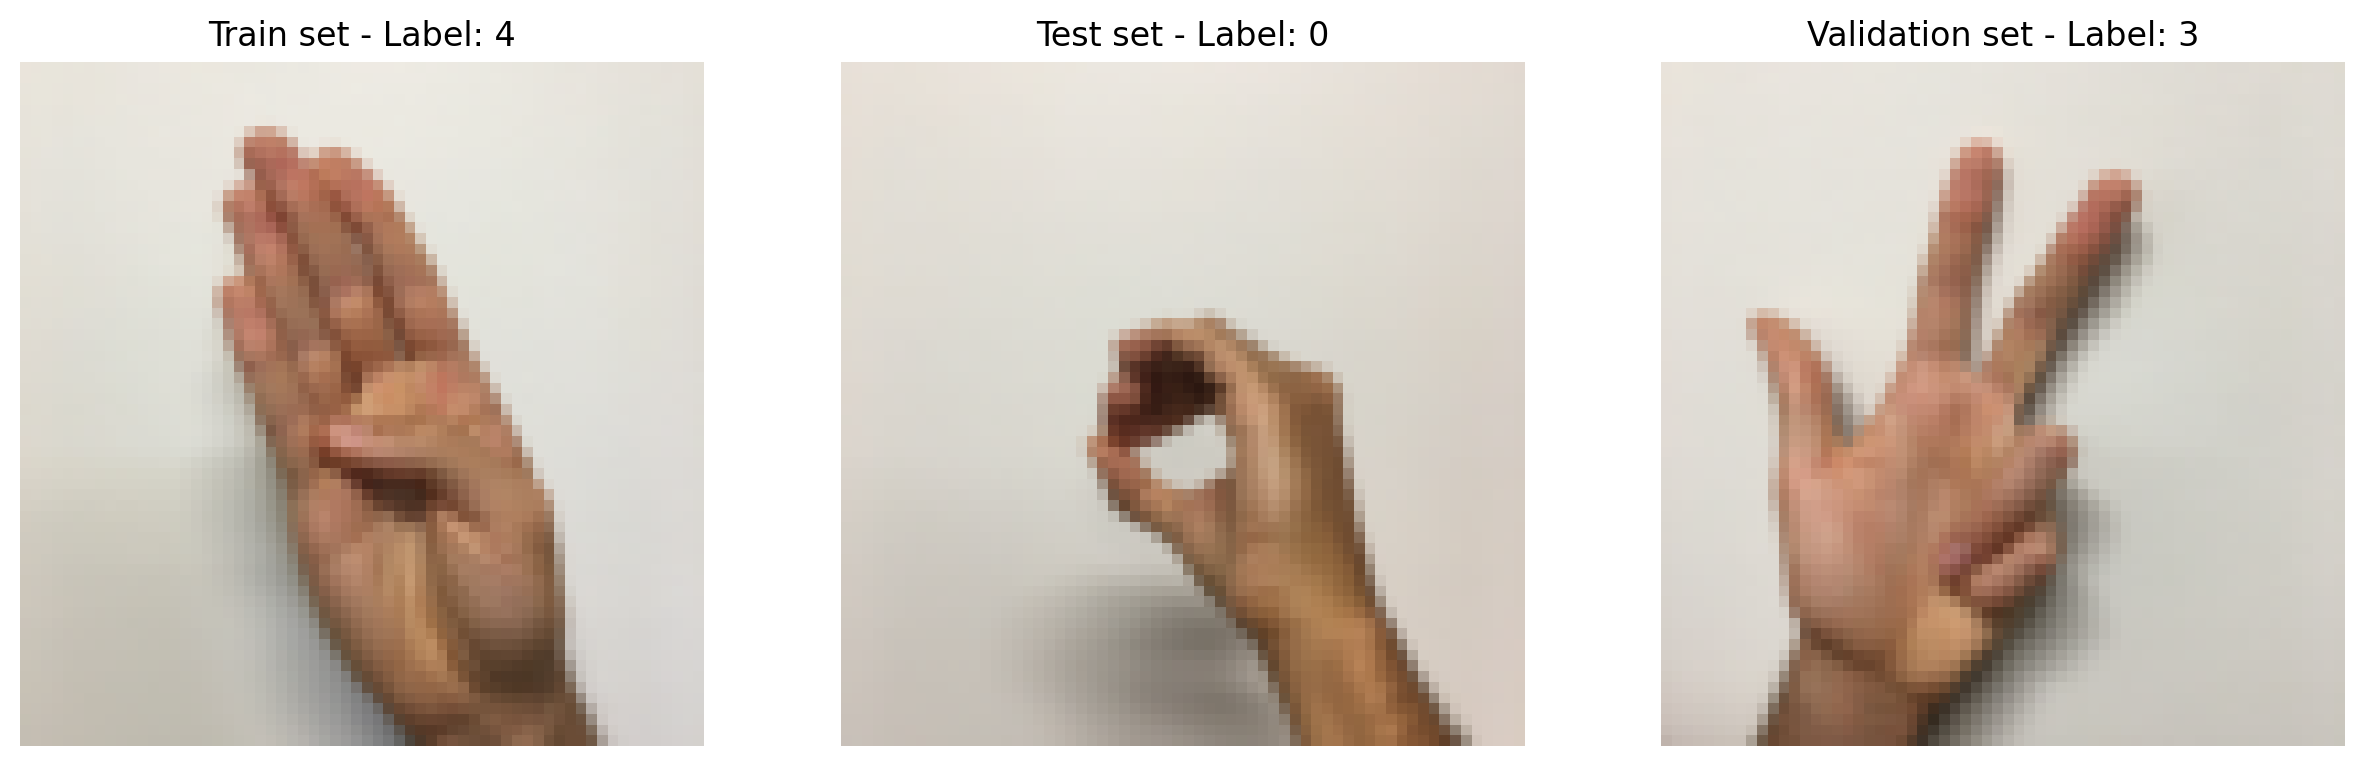

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))

# Training set example
axes[0].imshow(x_train[0])
axes[0].set_title(f"Train set - Label: {y_train[0]}")
axes[0].axis('off') 

# Testing set example
axes[1].imshow(x_test[0])
axes[1].set_title(f"Test set - Label: {y_test[0]}")
axes[1].axis('off')

# Validation set example
axes[2].imshow(x_val[0])
axes[2].set_title(f"Validation set - Label: {y_val[0]}")
axes[2].axis('off')

plt.show()

3


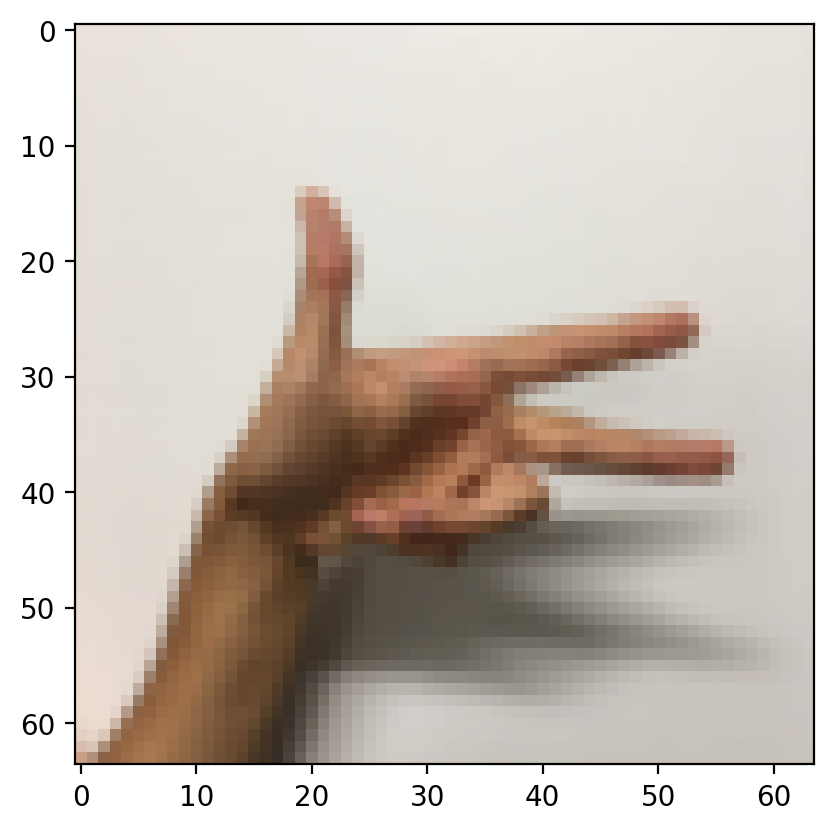

In [4]:
print(y_train[5])
plt.imshow(x_train[5])

In [5]:
print("Before encoding:")
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_val shape:", y_val.shape)

Before encoding:
y_train shape: (864,)
y_test shape: (120,)
y_val shape: (216,)


In [6]:
num_classes = 6

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

In [7]:
print("After encoding:")
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("y_val shape:", y_val.shape)

After encoding:
y_train shape: (864, 6)
y_test shape: (120, 6)
y_val shape: (216, 6)


In [8]:
print(y_train[5])

[0. 0. 0. 1. 0. 0.]


In [9]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255
x_test /= 255
x_val /= 255

## Deep learning

### Model 1 - CNN (Simple)
Optimizer: RMSprop

Architecture :
* Conv
* Conv
* MaxPool
* Flatten
* Dense
* Final Classification

In [10]:
# Model definition
model_1 = Sequential()

# 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=x_train.shape[1:]))
model_1.add(Activation('relu'))

# Another 5x5 convolution with 2x2 stride and 32 filters
model_1.add(Conv2D(32, (5, 5), strides=(2, 2)))
model_1.add(Activation('relu'))

# 2x2 max pooling
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))

# Flatten and dense layers
model_1.add(Flatten())
model_1.add(Dense(512))
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes))
model_1.add(Activation('softmax'))

In [11]:
opt = keras.optimizers.RMSprop(learning_rate=0.0005)
model_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [12]:
batch_size = 32
t1 = datetime.now()
history_1 = model_1.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=15,
            validation_data=(x_val, y_val),
            shuffle=True)
train_time_1 = datetime.now() - t1
train_time_1 = train_time_1.total_seconds()

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.1821 - loss: 1.8048 - val_accuracy: 0.1713 - val_loss: 1.7584
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3066 - loss: 1.7161 - val_accuracy: 0.4954 - val_loss: 1.5625
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4717 - loss: 1.4801 - val_accuracy: 0.5972 - val_loss: 1.3592
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5444 - loss: 1.2901 - val_accuracy: 0.7083 - val_loss: 1.0510
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6251 - loss: 1.1003 - val_accuracy: 0.6574 - val_loss: 0.9395
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6380 - loss: 0.9714 - val_accuracy: 0.7269 - val_loss: 0.8228
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7147 - loss: 0.8462 - val_accuracy: 0.7778 - val_loss: 0.7500
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7446 - loss: 0.7412 - val_accuracy: 0.7870 - val_loss

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Accuracy of predictions on the test set: 91.67%


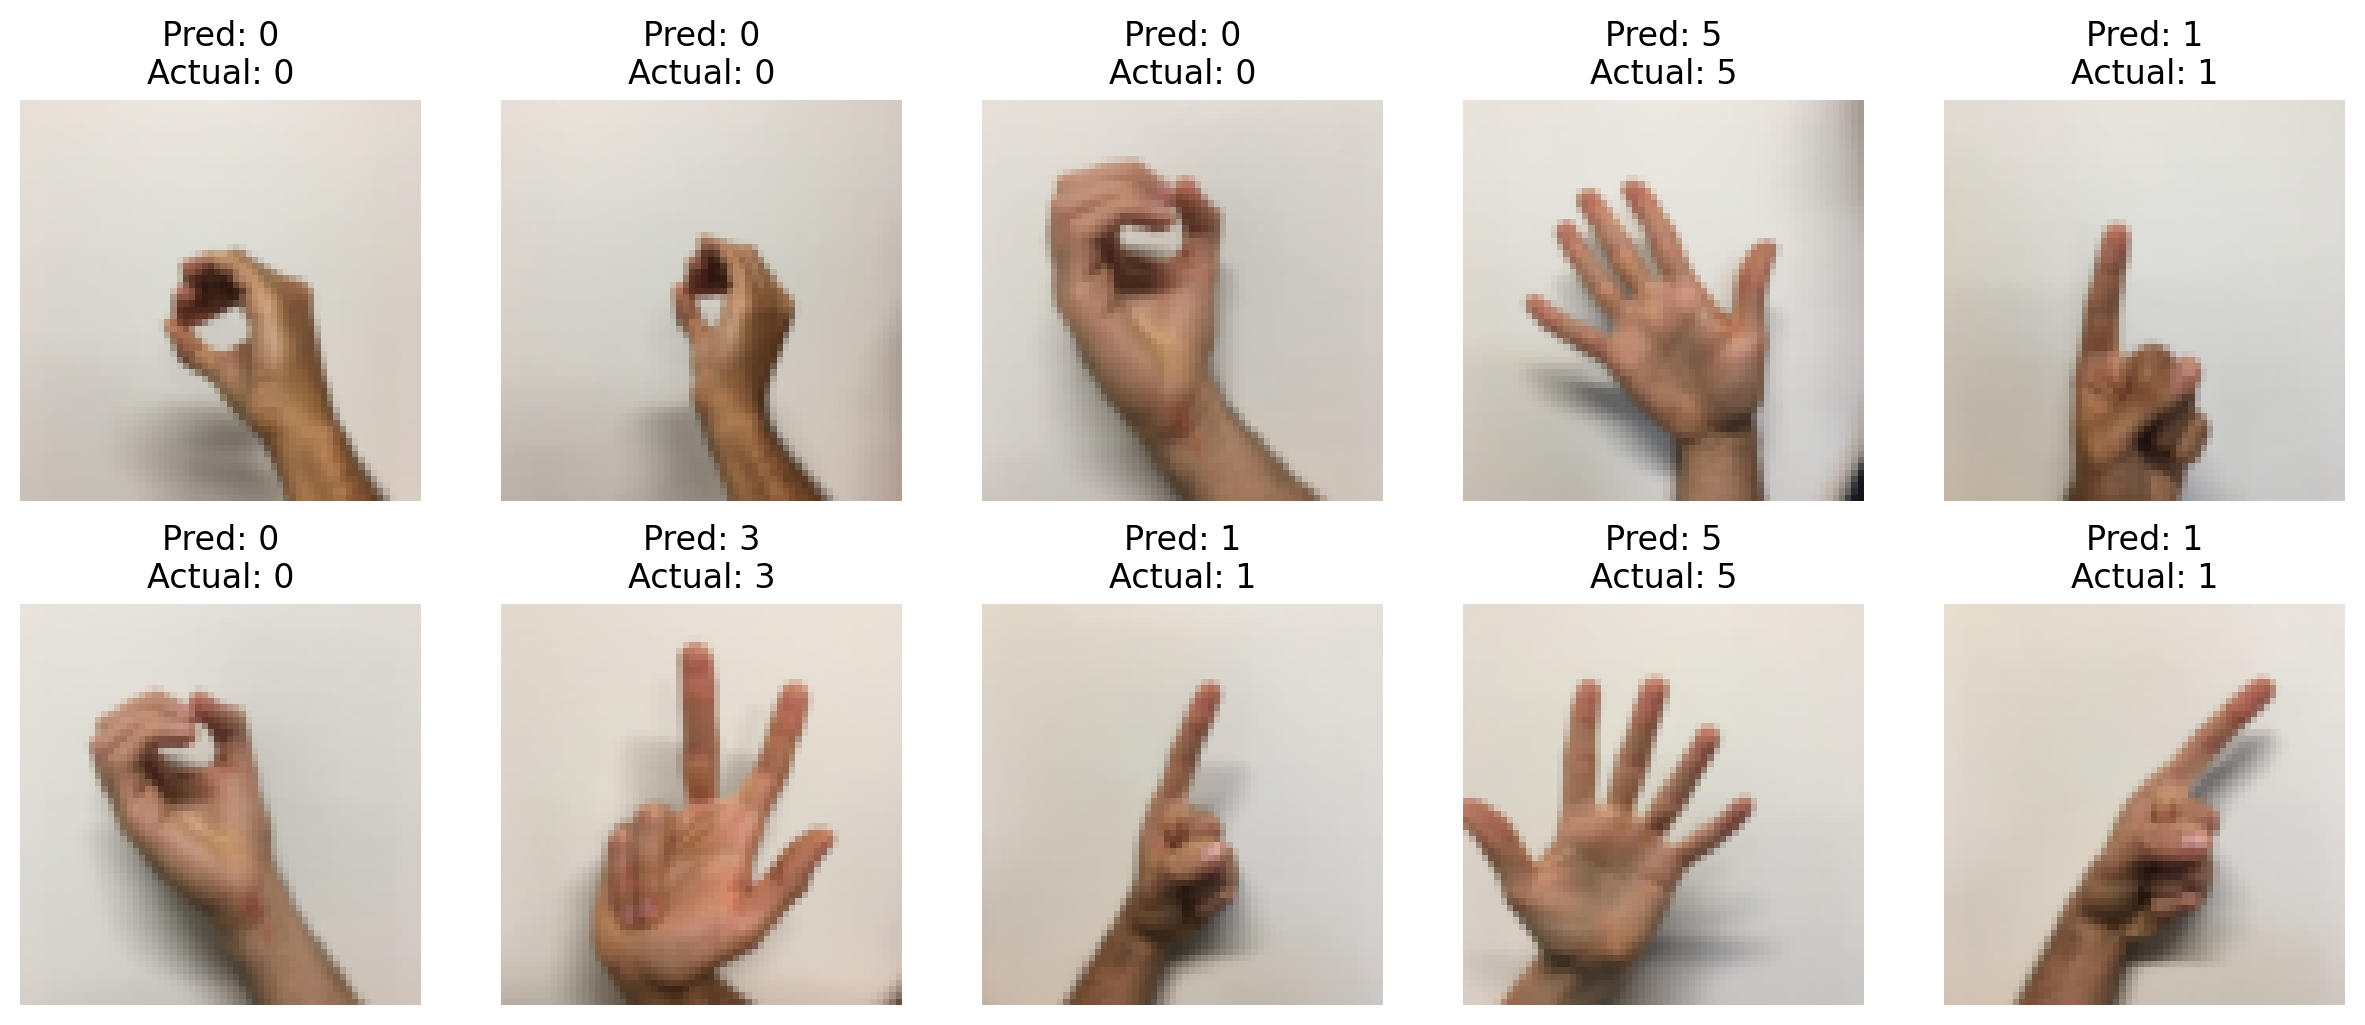

In [13]:
y_pred_1 = model_1.predict(x_test, batch_size=32)

y_pred_classes_1 = np.argmax(y_pred_1, axis=1)
y_test_classes_1 = np.argmax(y_test, axis=1)

correct_1 = np.sum(y_pred_classes_1 == y_test_classes_1)
total_1 = len(y_test_classes_1)
accuracy_comparison_1 = correct_1 / total_1

print(f"Accuracy of predictions on the test set: {accuracy_comparison_1 * 100:.2f}%")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(10):
    ax = axes[i // 5, i % 5] 
    ax.imshow(x_test[i])
    ax.set_title(f"Pred: {list_classes_test[y_pred_classes_1[i]]}\nActual: {list_classes_test[y_test_classes_1[i]]}")
    ax.axis('off')

plt.show()

### Model 2 - CNN (Complex) - RMS optimizer
Optimizer: RMSprop

Architecture:
* Conv
* Conv
* MaxPool
* Conv
* Conv
* MaxPool
* Flatten
* Dense
* Final Classification

In [14]:
model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model_2.add(Activation('relu'))
model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(64, (3, 3), padding='same'))
model_2.add(Activation('relu'))
model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(512))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 31, 31, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 29, 29, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           3,078 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 6)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,491,686 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
opt_2 = keras.optimizers.RMSprop(learning_rate=0.0005)

model_2.compile(loss='categorical_crossentropy',
              optimizer=opt_2,
              metrics=['accuracy'])

In [16]:
t2 = datetime.now()
history_2 = model_2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=15,
              validation_data=(x_test, y_test),
              shuffle=True)
train_time_2 = datetime.now() - t2

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.1847 - loss: 2.0854 - val_accuracy: 0.1667 - val_loss: 1.7907
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.1876 - loss: 1.7884 - val_accuracy: 0.2750 - val_loss: 1.7621
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.2563 - loss: 1.7274 - val_accuracy: 0.4750 - val_loss: 1.5044
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.4237 - loss: 1.5295 - val_accuracy: 0.6083 - val_loss: 1.2165
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.5450 - loss: 1.2195 - val_accuracy: 0.7833 - val_loss: 0.9202
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.6281 - loss: 0.9833 - val_accuracy: 0.7000 - val_loss: 0.8660
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.6618 - loss: 0.9056 - val_accuracy: 0.8083 - val_loss: 0.6564
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7826 - loss: 0.6554 - val_accuracy: 0.6667 - v

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Accuracy of predictions on the test set: 88.33%


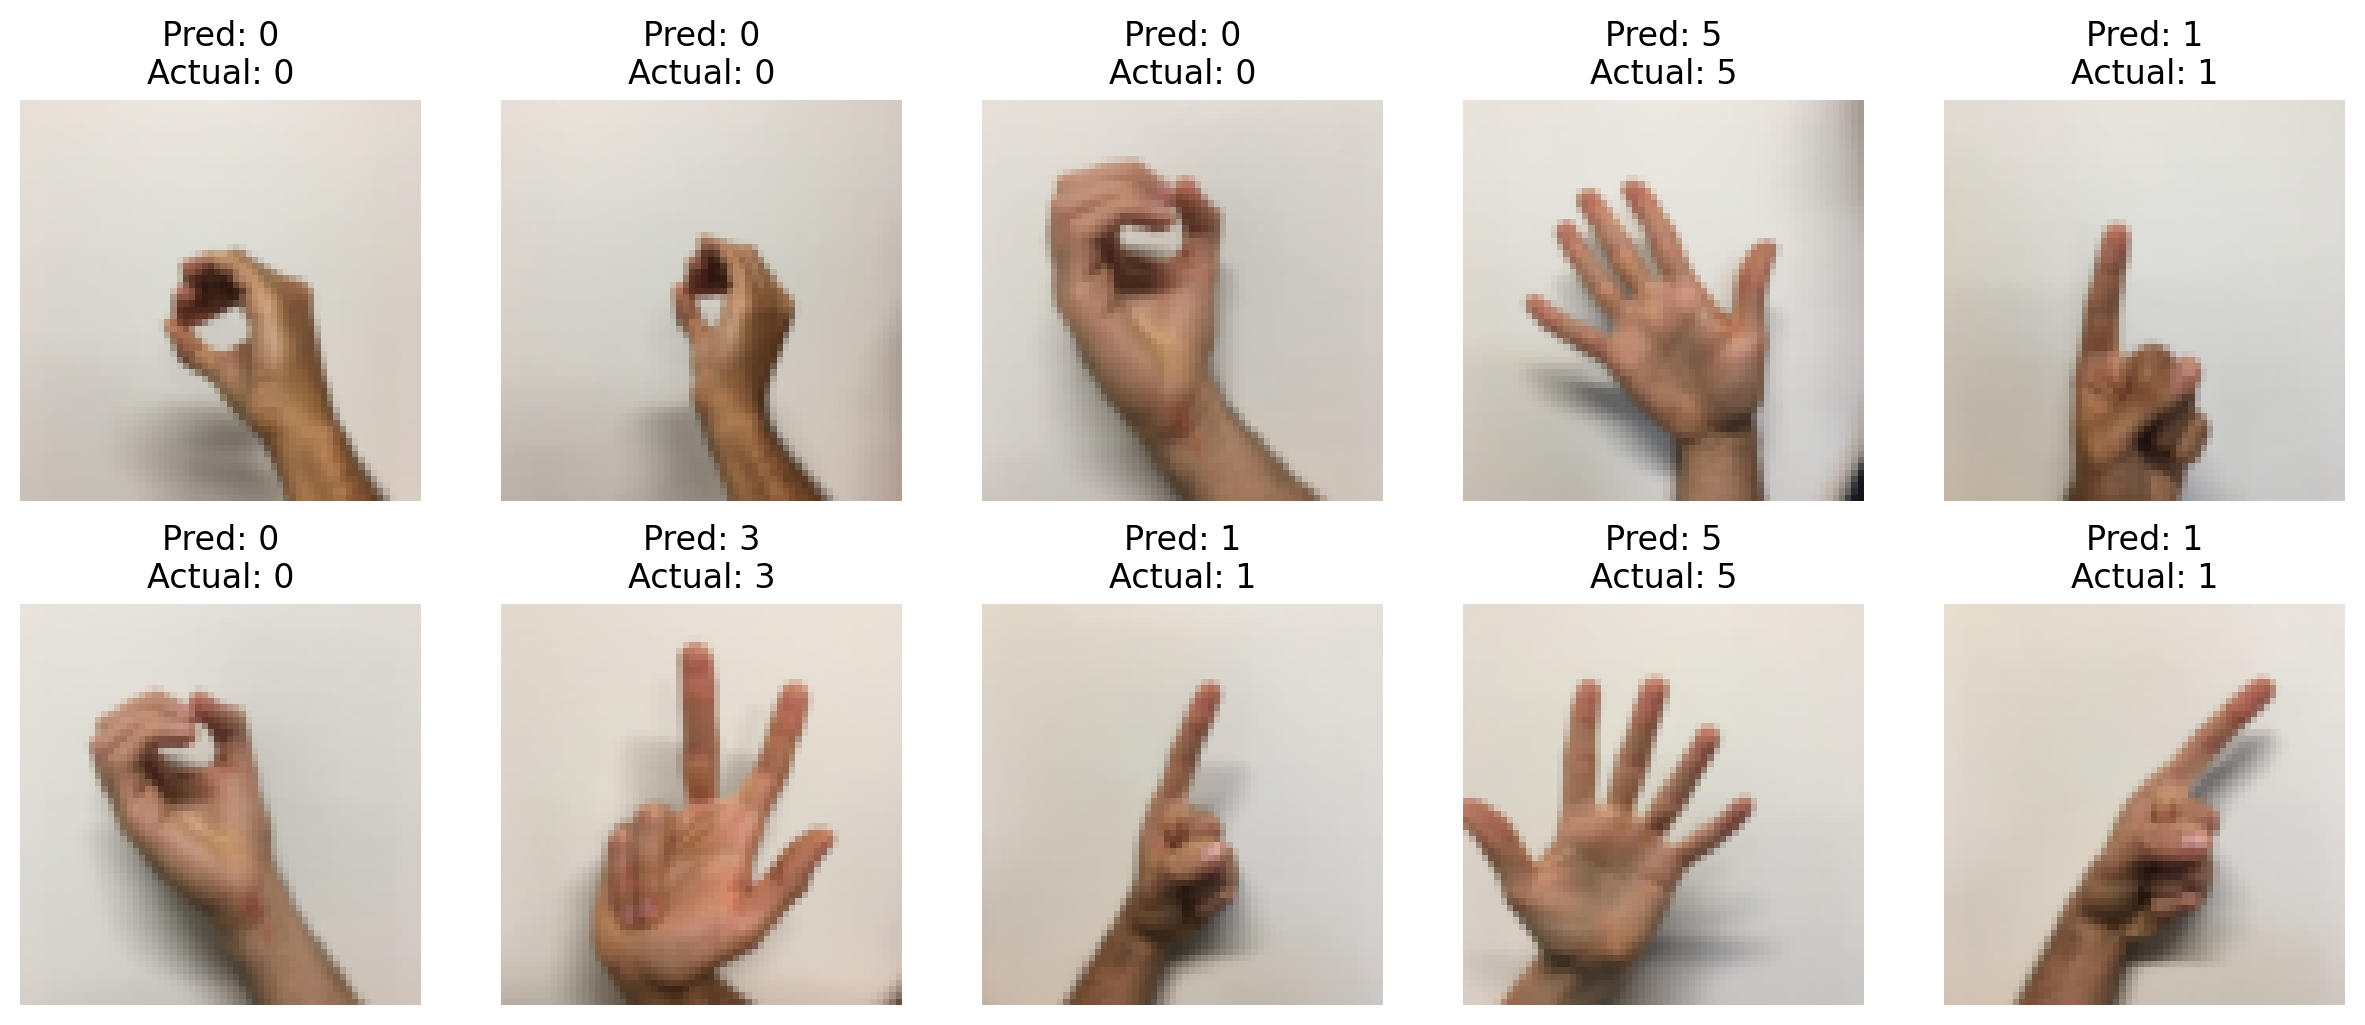

In [17]:
y_pred_2 = model_2.predict(x_test, batch_size=32)

y_pred_classes_2 = np.argmax(y_pred_2, axis=1)
y_test_classes_2 = np.argmax(y_test, axis=1)

correct_2 = np.sum(y_pred_classes_2 == y_test_classes_2)
total_2 = len(y_test_classes_2)
accuracy_comparison_2 = correct_2 / total_2

print(f"Accuracy of predictions on the test set: {accuracy_comparison_2 * 100:.2f}%")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(10):
    ax = axes[i // 5, i % 5] 
    ax.imshow(x_test[i])
    ax.set_title(f"Pred: {list_classes_test[y_pred_classes_2[i]]}\nActual: {list_classes_test[y_test_classes_2[i]]}")
    ax.axis('off')

plt.show()

### Model 3 - CNN (Complex) - Adam optimizer
Optimizer: Adam

Architecture: Similar to Model 2

In [18]:
model_3 = Sequential()

model_3.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model_3.add(Activation('relu'))
model_3.add(Conv2D(32, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Conv2D(64, (3, 3), padding='same'))
model_3.add(Activation('relu'))
model_3.add(Conv2D(64, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.25))

model_3.add(Flatten())
model_3.add(Dense(512))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(num_classes))
model_3.add(Activation('softmax'))

model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 62, 62, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 31, 31, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 29, 29, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 29, 29, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       6,423,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 6)                   │           3,078 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 6)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,491,686 (24.76 MB)

 Trainable params: 6,491,686 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
t3 = datetime.now()
history_3 = model_3.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=15,
              validation_data=(x_test, y_test),
              shuffle=True)
train_time_3 = datetime.now() - t3

Epoch 1/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.1861 - loss: 1.8246 - val_accuracy: 0.2750 - val_loss: 1.7895
Epoch 2/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.2103 - loss: 1.7816 - val_accuracy: 0.4333 - val_loss: 1.5891
Epoch 3/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.3605 - loss: 1.5954 - val_accuracy: 0.5833 - val_loss: 1.1027
Epoch 4/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5762 - loss: 1.1193 - val_accuracy: 0.6667 - val_loss: 0.8635
Epoch 5/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.6713 - loss: 0.8161 - val_accuracy: 0.7500 - val_loss: 0.6489
Epoch 6/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.7561 - loss: 0.6738 - val_accuracy: 0.7417 - val_loss: 0.6100
Epoch 7/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.7904 - loss: 0.5389 - val_accuracy: 0.8583 - val_loss: 0.3849
Epoch 8/15
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.8616 - loss: 0.4470 - val_accuracy: 0.8250 - v

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000029D6698B1A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Accuracy of predictions on the test set: 90.00%


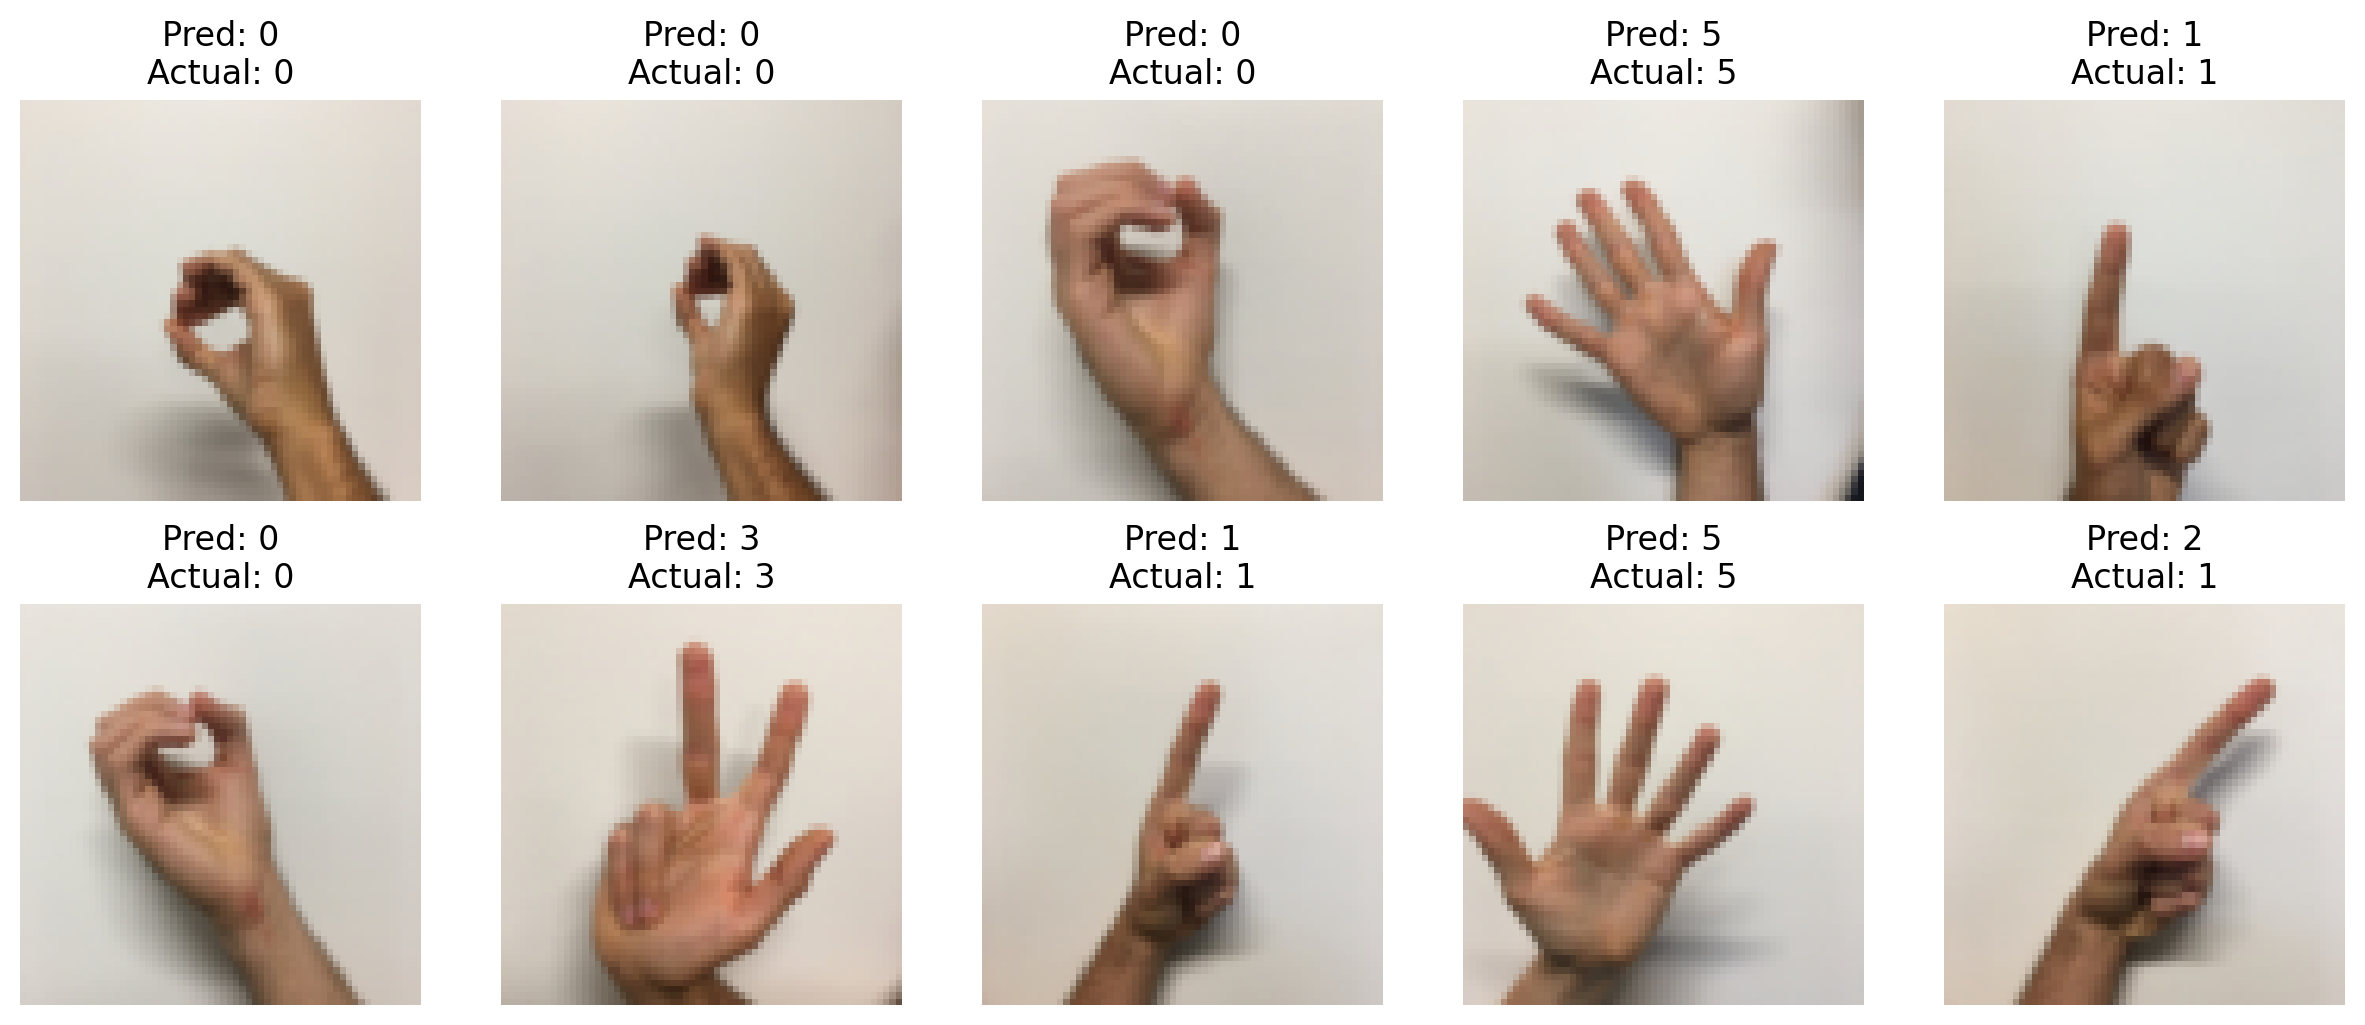

In [21]:
y_pred_3 = model_3.predict(x_test, batch_size=32)

y_pred_classes_3 = np.argmax(y_pred_3, axis=1)
y_test_classes_3 = np.argmax(y_test, axis=1)

correct_3 = np.sum(y_pred_classes_3 == y_test_classes_3)
total_3 = len(y_test_classes_3)
accuracy_comparison_3 = correct_3 / total_3

print(f"Accuracy of predictions on the test set: {accuracy_comparison_3 * 100:.2f}%")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(10):
    ax = axes[i // 5, i % 5] 
    ax.imshow(x_test[i])
    ax.set_title(f"Pred: {list_classes_test[y_pred_classes_3[i]]}\nActual: {list_classes_test[y_test_classes_3[i]]}")
    ax.axis('off')

plt.show()

## Results

### Training time

In [22]:
print(f'Model 1 took {train_time_1} seconds to be trained')
print(f'Model 2 took {train_time_2} seconds to be trained')
print(f'Model 3 took {train_time_3} seconds to be trained')

Model 1 took 4.148909 seconds to be trained
Model 2 took 0:00:30.688826 seconds to be trained
Model 3 took 0:00:34.093996 seconds to be trained


### Loss and Accuracy

In [23]:
loss_1, test_accuracy_1 = model_1.evaluate(x_test, y_test, batch_size=32)
loss_2, test_accuracy_2 = model_2.evaluate(x_test, y_test, batch_size=32)
loss_3, test_accuracy_3 = model_3.evaluate(x_test, y_test, batch_size=32)

print('\nModel 1 - Loss on the TEST Set: {:,.3f}'.format(loss_1))
print('Model 2 - Accuracy on the TEST Set: {:.3%}'.format(test_accuracy_1))
print('\nModel 2 - Loss on the TEST Set: {:,.3f}'.format(loss_2))
print('Model 2- Accuracy on the TEST Set: {:.3%}'.format(test_accuracy_2))
print('\nModel 2 - Loss on the TEST Set: {:,.3f}'.format(loss_3))
print('Model 2- Accuracy on the TEST Set: {:.3%}'.format(test_accuracy_3))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9240 - loss: 0.3159 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8992 - loss: 0.3577
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8923 - loss: 0.2800

Model 1 - Loss on the TEST Set: 0.337
Model 2 - Accuracy on the TEST Set: 91.667%

Model 2 - Loss on the TEST Set: 0.379
Model 2- Accuracy on the TEST Set: 88.333%

Model 2 - Loss on the TEST Set: 0.276
Model 2- Accuracy on the TEST Set: 90.000%


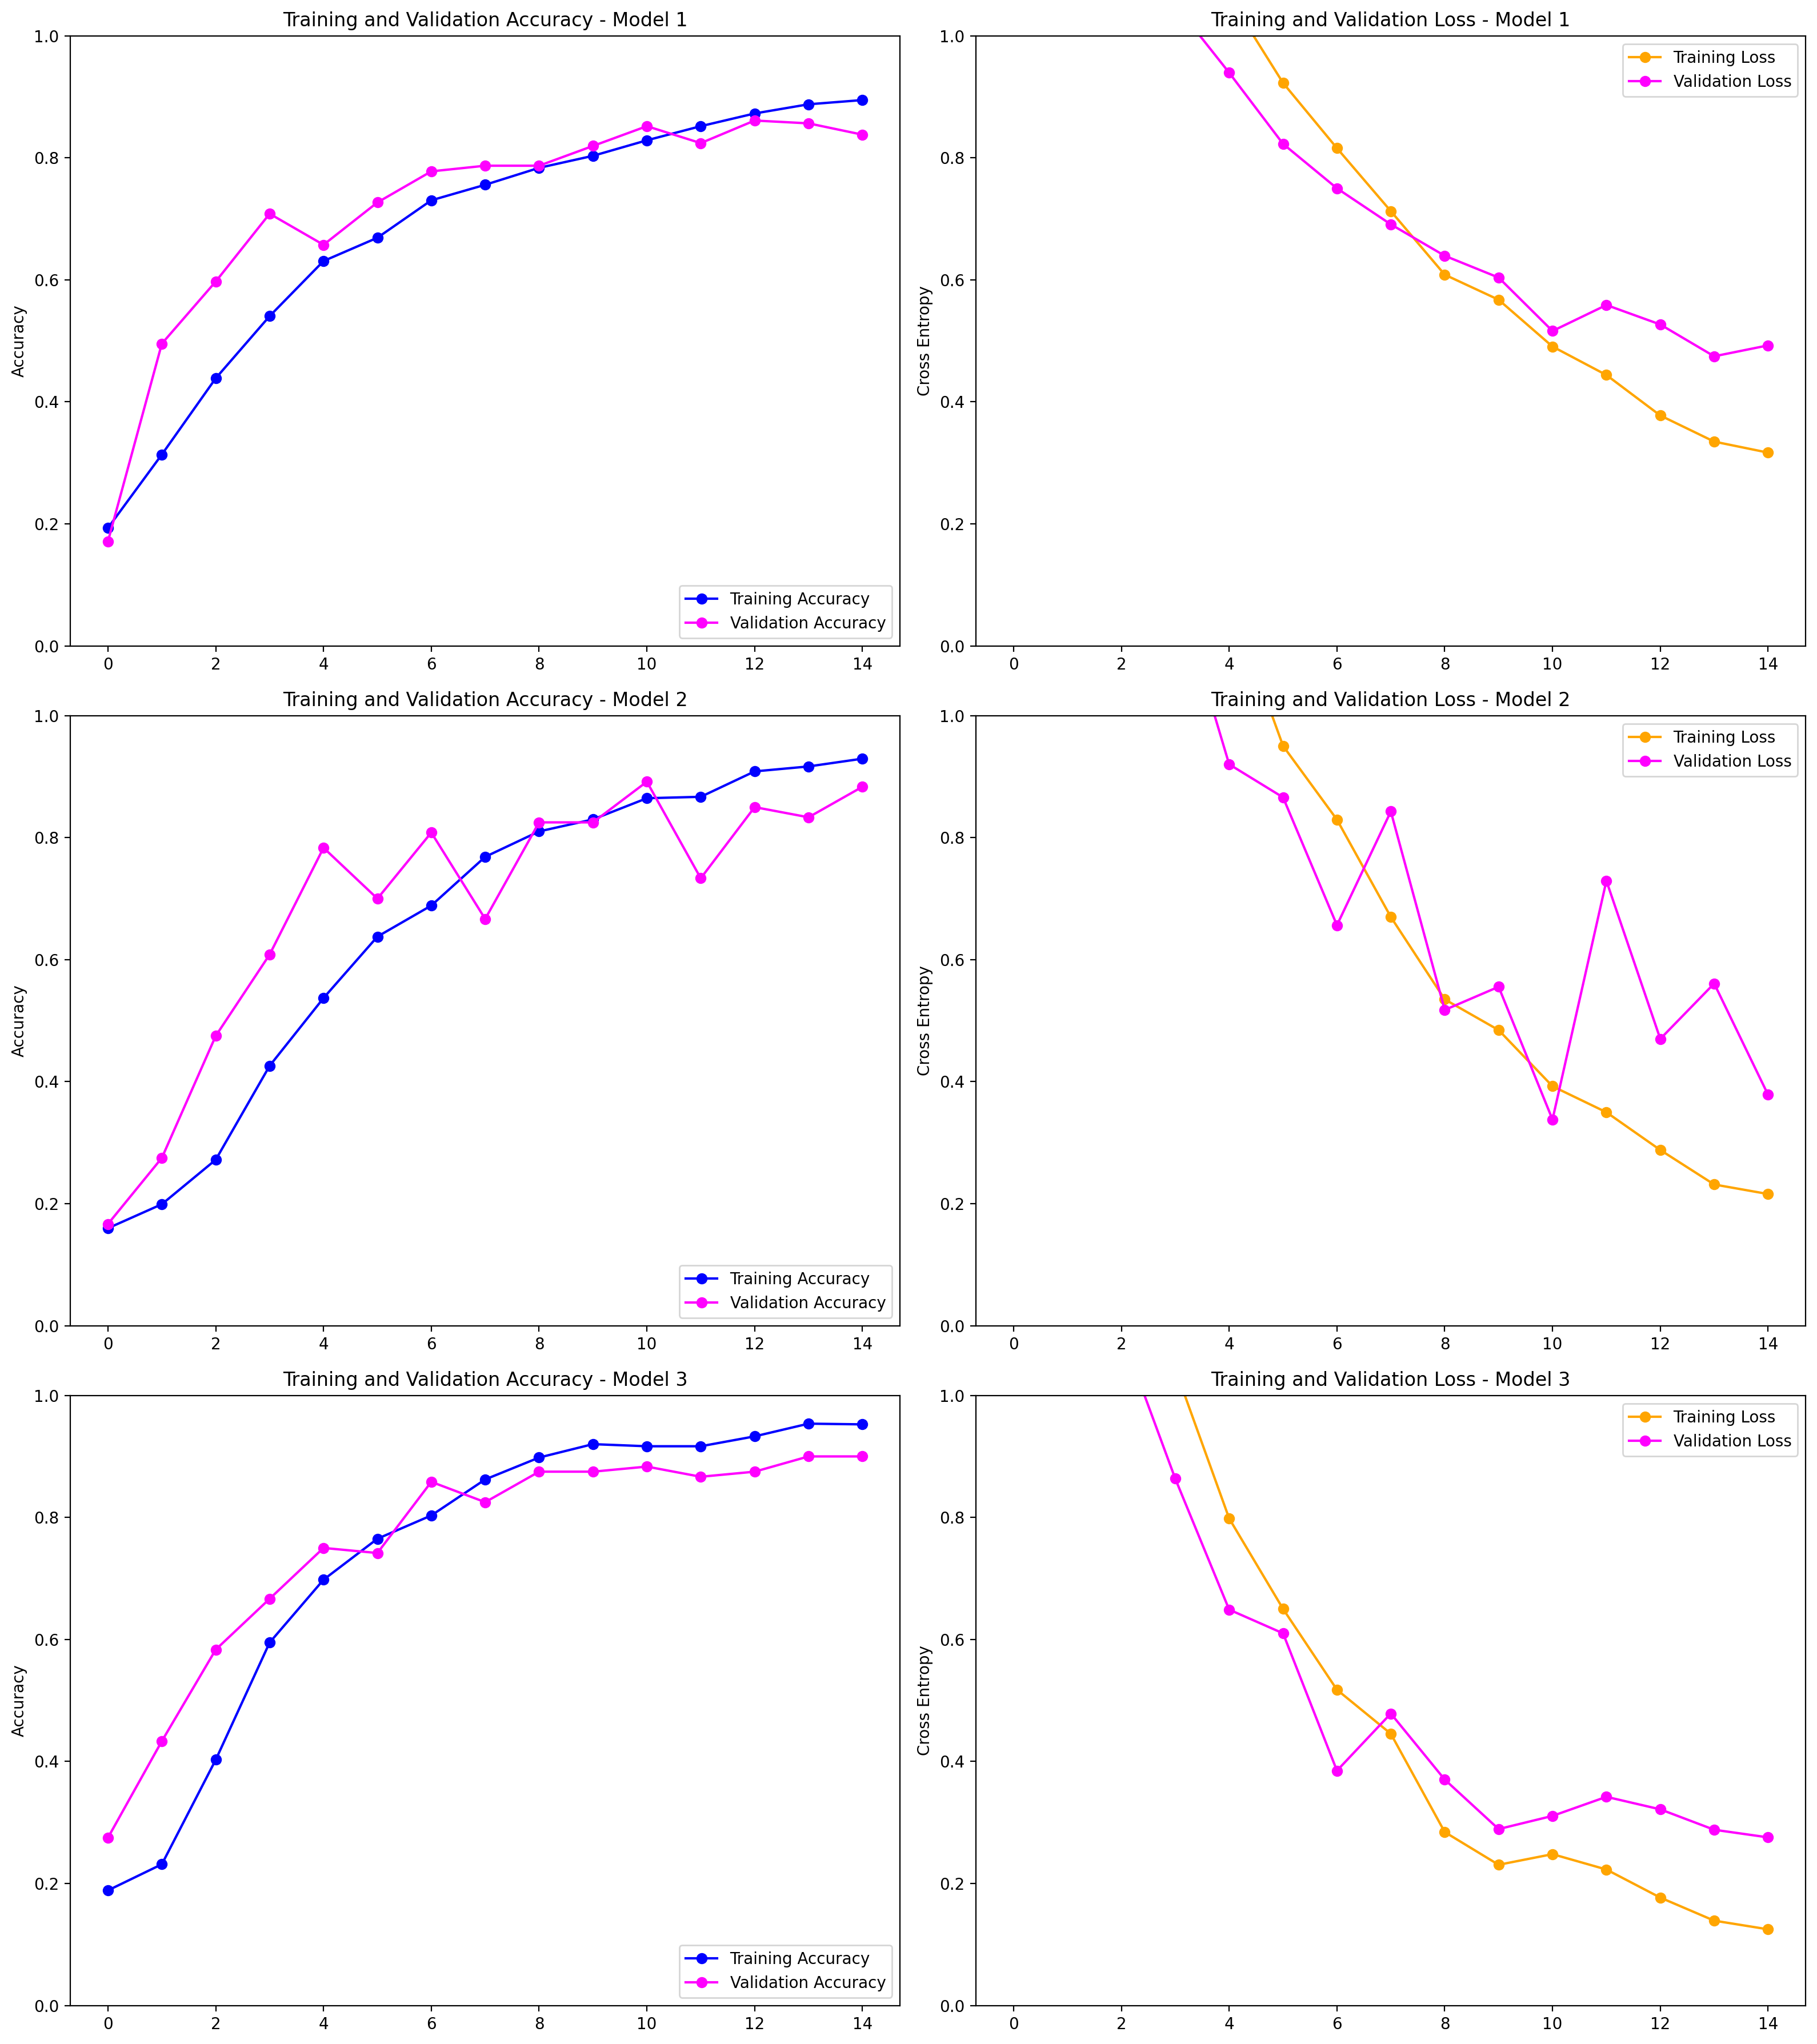

In [24]:
# Accuracy and Loss for Model 1
acc_1 = history_1.history['accuracy']
val_acc_1 = history_1.history['val_accuracy']
loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

# Accuracy and Loss for Model 2
acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

# Accuracy and Loss for Model 3
acc_3 = history_3.history['accuracy']
val_acc_3 = history_3.history['val_accuracy']
loss_3 = history_3.history['loss']
val_loss_3 = history_3.history['val_loss']

# Create a 3x2 grid of subplots with adjusted figure size
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# Plot Accuracy for Model 1
axes[0, 0].plot(acc_1, label='Training Accuracy', marker='o', color="blue")
axes[0, 0].plot(val_acc_1, label='Validation Accuracy', marker='o', color="magenta")
axes[0, 0].legend(loc='lower right')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([min(plt.ylim()), 1])
axes[0, 0].set_title('Training and Validation Accuracy - Model 1')

# Plot Loss for Model 1
axes[0, 1].plot(loss_1, label='Training Loss', marker='o', color="orange")
axes[0, 1].plot(val_loss_1, label='Validation Loss', marker='o', color="magenta")
axes[0, 1].legend(loc='upper right')
axes[0, 1].set_ylabel('Cross Entropy')
axes[0, 1].set_ylim([0, 1.0])
axes[0, 1].set_title('Training and Validation Loss - Model 1')

# Plot Accuracy for Model 2
axes[1, 0].plot(acc_2, label='Training Accuracy', marker='o', color="blue")
axes[1, 0].plot(val_acc_2, label='Validation Accuracy', marker='o', color="magenta")
axes[1, 0].legend(loc='lower right')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_ylim([min(plt.ylim()), 1])
axes[1, 0].set_title('Training and Validation Accuracy - Model 2')

# Plot Loss for Model 2
axes[1, 1].plot(loss_2, label='Training Loss', marker='o', color="orange")
axes[1, 1].plot(val_loss_2, label='Validation Loss', marker='o', color="magenta")
axes[1, 1].legend(loc='upper right')
axes[1, 1].set_ylabel('Cross Entropy')
axes[1, 1].set_ylim([0, 1.0])
axes[1, 1].set_title('Training and Validation Loss - Model 2')

# Plot Accuracy for Model 3
axes[2, 0].plot(acc_3, label='Training Accuracy', marker='o', color="blue")
axes[2, 0].plot(val_acc_3, label='Validation Accuracy', marker='o', color="magenta")
axes[2, 0].legend(loc='lower right')
axes[2, 0].set_ylabel('Accuracy')
axes[2, 0].set_ylim([min(plt.ylim()), 1])
axes[2, 0].set_title('Training and Validation Accuracy - Model 3')

# Plot Loss for Model 3
axes[2, 1].plot(loss_3, label='Training Loss', marker='o', color="orange")
axes[2, 1].plot(val_loss_3, label='Validation Loss', marker='o', color="magenta")
axes[2, 1].legend(loc='upper right')
axes[2, 1].set_ylabel('Cross Entropy')
axes[2, 1].set_ylim([0, 1.0])
axes[2, 1].set_title('Training and Validation Loss - Model 3')

# Adjust layout
plt.tight_layout()
plt.show()

### Confusion matrix

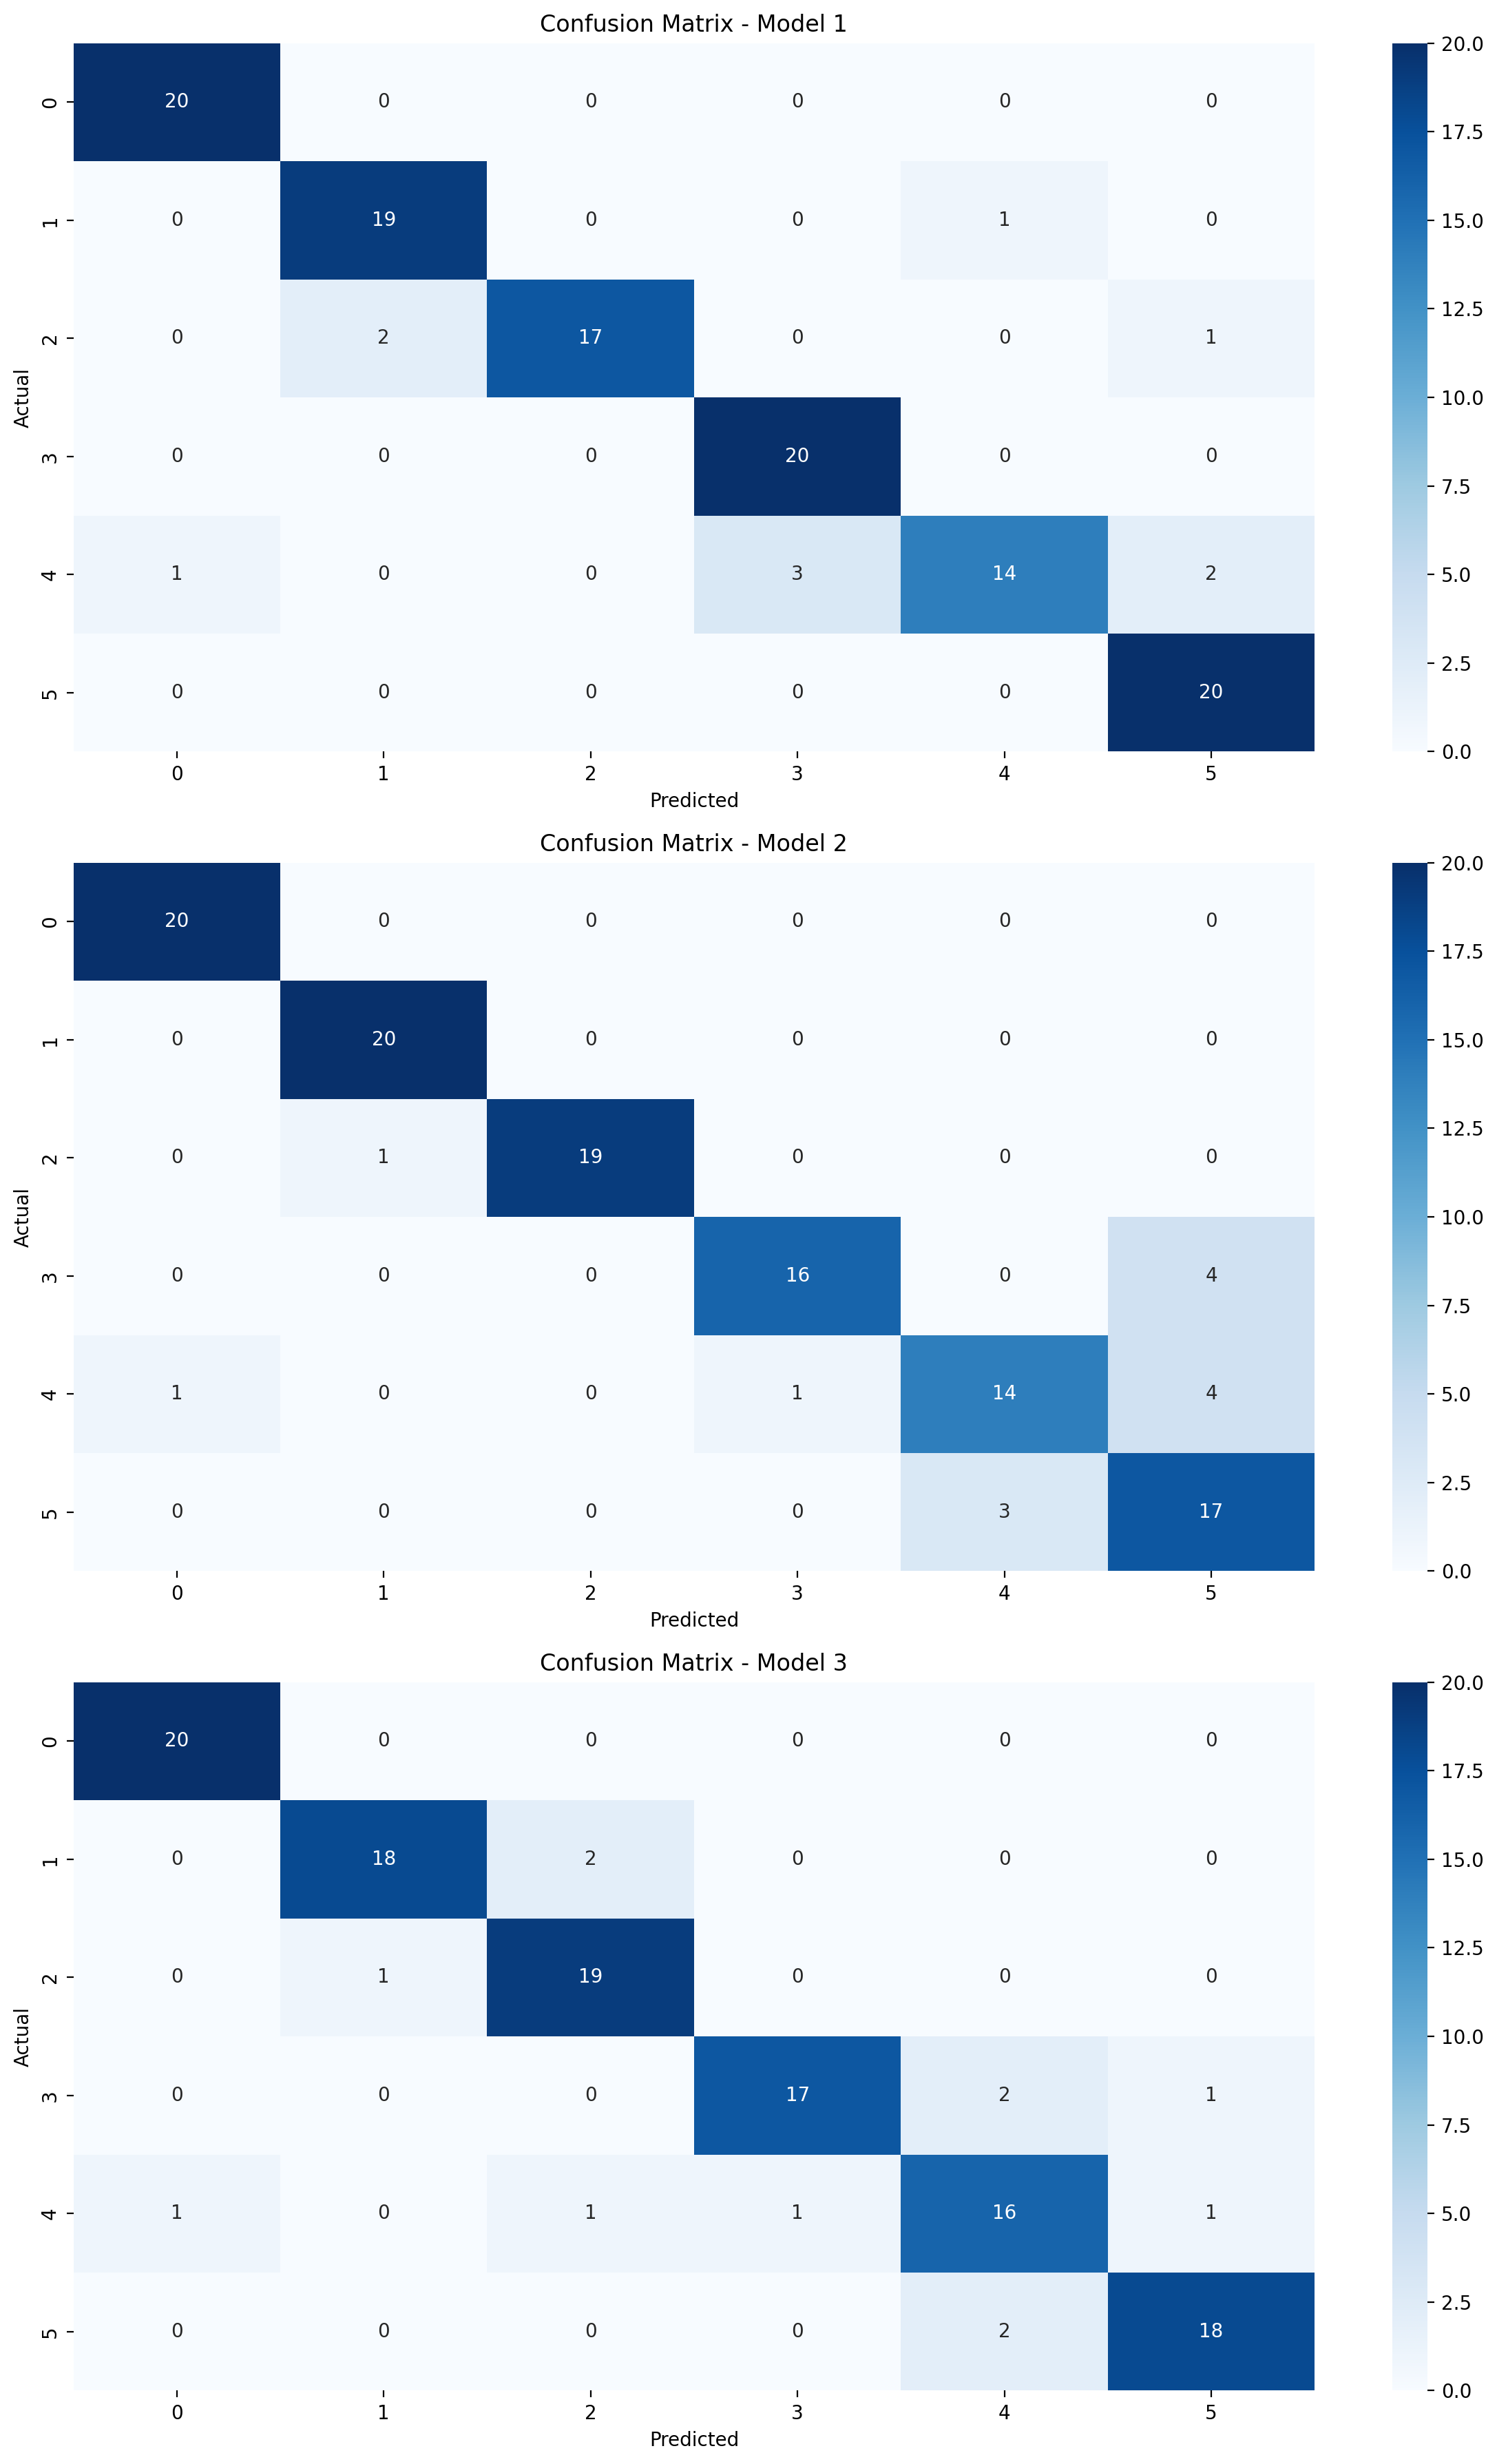

In [25]:
conf_matrix_1 = confusion_matrix(y_test_classes_1, y_pred_classes_1)
conf_matrix_2 = confusion_matrix(y_test_classes_2, y_pred_classes_2)
conf_matrix_3 = confusion_matrix(y_test_classes_3, y_pred_classes_3)

# Create a 3x1 grid of subplots to fit all confusion matrices
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot Confusion Matrix for Model 1
sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list_classes_test, yticklabels=list_classes_test, ax=axes[0])
axes[0].set_title("Confusion Matrix - Model 1")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Plot Confusion Matrix for Model 2
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list_classes_test, yticklabels=list_classes_test, ax=axes[1])
axes[1].set_title("Confusion Matrix - Model 2")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

# Plot Confusion Matrix for Model 3
sns.heatmap(conf_matrix_3, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list_classes_test, yticklabels=list_classes_test, ax=axes[2])
axes[2].set_title("Confusion Matrix - Model 3")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Actual")

# Adjust layout
plt.tight_layout()
plt.show()

### Key insights

Model 1 is recommended for deployment as it achieves the highest test accuracy (91.67%) while maintaining a simple architecture and fast training time. This makes it an ideal choice for applications where computational efficiency is important.

* Preprocessing steps, including normalization and one-hot encoding, were crucial for model performance.
* Increasing model complexity with additional layers and dropout improved robustness but did not always yield higher accuracy.
* The optimizer choice significantly influenced performance, with RMSprop demonstrating better generalization than Adam for this dataset.

## Next steps

* Apply data augmentation techniques, such as rotation, flipping, and zooming, to improve model generalization.
* Experiment with transfer learning using pretrained models like MobileNet or ResNet for potentially higher accuracy.
* Conduct hyperparameter optimization to explore different learning rates, batch sizes, and activation functions.
* Expand the dataset to include more variations in finger sign images to increase robustness and scalability.